In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
from collections import Counter
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
)

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# 1. Parameters
BATCH_SIZE = 64
EMBED_DIM = 128
HIDDEN_DIM = 128
EPOCHS = 5
MAX_VOCAB_SIZE = 25_000
MAX_SEQ_LEN = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

In [7]:
import os

def load_imdb_data(data_dir, split):
    """Loads IMDB reviews from disk. Returns list of (label, text) tuples."""
    data = []
    for label in ('pos', 'neg'):
        labeled_dir = os.path.join(data_dir, split, label)
        for fname in os.listdir(labeled_dir):
            if fname.endswith('.txt'):
                with open(os.path.join(labeled_dir, fname), encoding='utf-8') as f:
                    text = f.read()
                    data.append((label, text))
    return data

# Example usage:
train_data = load_imdb_data('../../ML_Tinkering_Python/data/aclImdb', 'train')
test_data = load_imdb_data('../../ML_Tinkering_Python/data/aclImdb', 'test')

In [8]:
# 3. Build Vocabulary
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_list):
    for label, text in data_list:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(train_data),
    specials=["<unk>", "<pad>"],
    max_tokens=MAX_VOCAB_SIZE
)
vocab.set_default_index(vocab["<unk>"])

In [9]:
# 4. Text + Label Preprocessing
label_map = {"neg": 0, "pos": 1}

def process_text(text):
    tokens = tokenizer(text)
    token_ids = vocab(tokens)
    if len(token_ids) > MAX_SEQ_LEN:
        token_ids = token_ids[:MAX_SEQ_LEN]
    else:
        token_ids += [vocab["<pad>"]] * (MAX_SEQ_LEN - len(token_ids))
    return torch.tensor(token_ids, dtype=torch.long)

def process_label(label):
    return torch.tensor(label_map[label], dtype=torch.long)

In [10]:
# 5. Create PyTorch Dataset
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = []
        for label, text in samples:
            self.samples.append((process_text(text), process_label(label)))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

train_dataset = IMDBDataset(train_data)
test_dataset = IMDBDataset(test_data)

In [11]:
# 6. Handle Imbalanced Dataset (Weighted Loss)
labels = [label.item() for _, label in train_dataset]

class_counts = Counter(labels)

class_weights = [1.0 / class_counts[i] for i in range(len(class_counts))]

sample_weights = [class_weights[label] for label in labels]

sampler = WeightedRandomSampler(
    sample_weights
    , num_samples=len(sample_weights)
    , replacement=True
)

In [16]:
# 7. Create DataLoaders
train_loader = DataLoader(
    train_dataset
    , batch_size=BATCH_SIZE
    , sampler=sampler
    , num_workers=0  # <-- Fix: Use single process (avoid pickle issues)
)

test_loader = DataLoader(
    test_dataset
    , batch_size=BATCH_SIZE
    , shuffle=False
    , num_workers=0  # <-- Fix: Use single process (avoid pickle issues)
)

In [17]:
# 8. Define Model
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size
            , embed_dim
            , padding_idx=pad_idx
        )
        self.lstm = nn.LSTM(
            embed_dim
            , hidden_dim
            , batch_first=True
        )
        self.fc = nn.Linear(
            hidden_dim
            , num_classes
        )
    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        # hidden: (1, batch, hidden_dim)
        out = self.fc(hidden[-1])
        return out

model = SimpleLSTM(
    vocab_size=len(vocab)
    , embed_dim=EMBED_DIM
    , hidden_dim=HIDDEN_DIM
    , num_classes=2
    , pad_idx=vocab["<pad>"]
).to(DEVICE)

In [18]:
# 9. Loss and Optimizer
# Use weighted cross entropy to deal with class imbalance

# weights
weights = torch.tensor(
    class_weights
    , dtype=torch.float
).to(DEVICE)

# criterion (CEL)
criterion = nn.CrossEntropyLoss(
    weight=weights)

# Optimizer (ADAM)
optimizer = optim.Adam(
    model.parameters(), lr=1e-3
)

In [19]:
# 10. Training Loop

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
        preds = output.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_x.size(0)
    acc = correct / total
    print(f"Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={acc:.4f}")

SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 1: Loss=0.6844, Acc=0.5322


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 2: Loss=0.6842, Acc=0.5410


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 3: Loss=0.6795, Acc=0.5518


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 4: Loss=0.5839, Acc=0.6693


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Epoch 5: Loss=0.3127, Acc=0.8754


In [20]:
# 11. Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        output = model(batch_x)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["neg", "pos"]))

SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

              precision    recall  f1-score   support

         neg       0.85      0.81      0.83     12500
         pos       0.82      0.85      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [21]:
confusion_matrix(all_labels, all_preds)

array([[10150,  2350],
       [ 1852, 10648]])

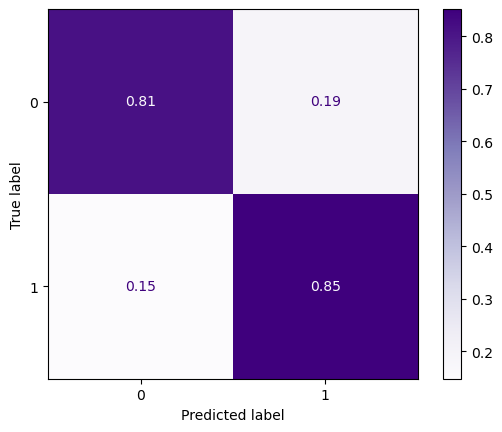

In [23]:
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize='true', cmap='Purples'
)